In [1]:
#!python Test_UKF_ode.py

In [2]:
from Test_UKF_ode import f_odes
from Test_UKF_solver import f_solve

import Test_UKF_params as param
import numpy as np
import matplotlib.pyplot as plt

In [3]:
t_eval = np.arange(1,86402,300)
D = 75000

In [4]:
G_start = param.G_pl_b
I_start = param.I_pl_b
y0 = np.array([0,G_start,I_start,G_start])   

In [5]:
sim = f_solve(f_odes, y0, t_eval, D)

In [6]:
len(sim[:,3])

289

In [7]:
noise = np.random.normal(0, 0.2, sim.shape[0])

In [8]:
sim[:,3]+=noise

In [9]:
#sim[:,3]

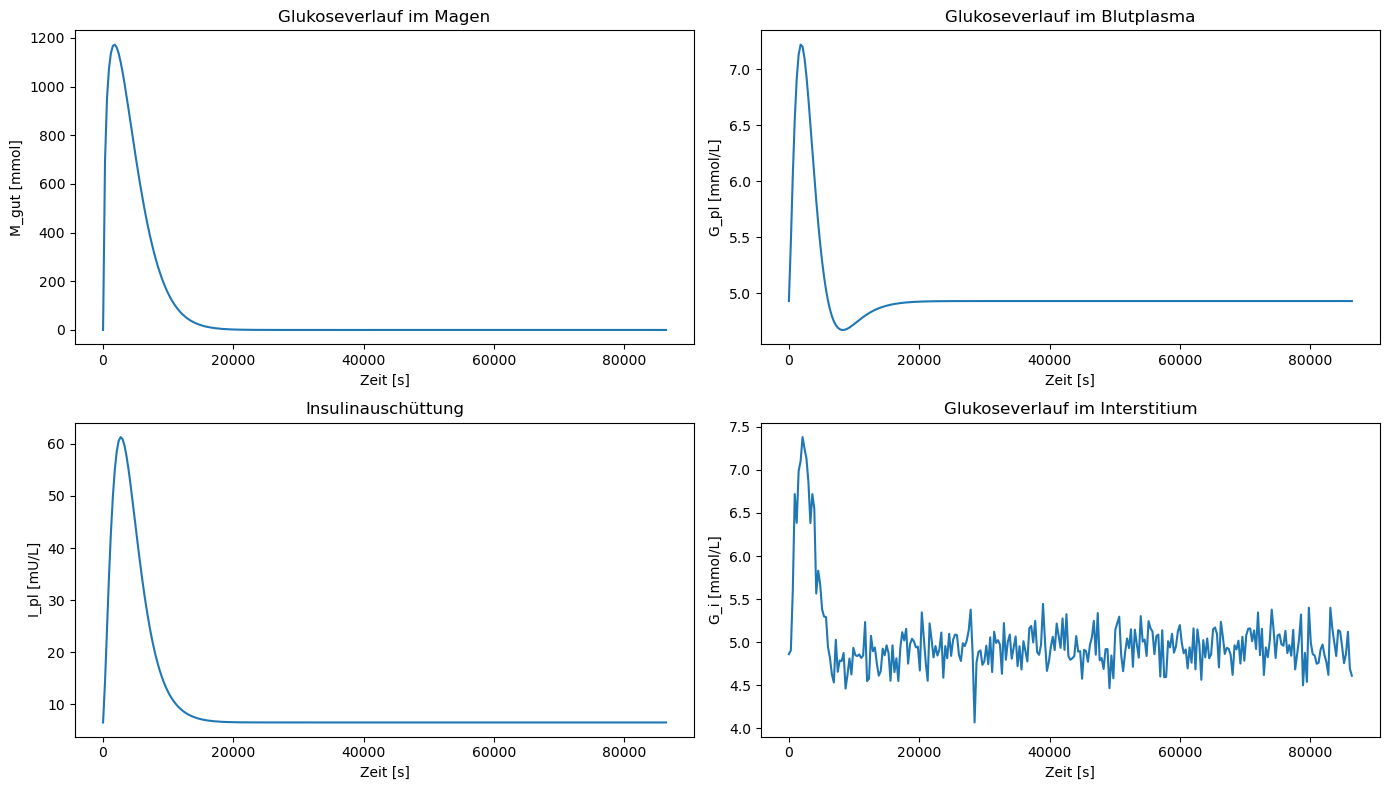

In [10]:
fig, ax = plt.subplots(2,2, figsize=(14,8))
ax[0,0].plot(t_eval, sim[:,0])
ax[0,0].set_title('Glukoseverlauf im Magen')
ax[0,1].plot(t_eval, sim[:,1])
ax[0,1].set_title('Glukoseverlauf im Blutplasma')
ax[1,0].plot(t_eval, sim[:,2])
ax[1,0].set_title('Insulinauschüttung')
ax[1,1].plot(t_eval, sim[:,3])
ax[1,1].set_title('Glukoseverlauf im Interstitium')

ax[0,0].set_xlabel("Zeit [s]")
ax[0,0].set_ylabel("M_gut [mmol]")

ax[0,1].set_xlabel("Zeit [s]")
ax[0,1].set_ylabel("G_pl [mmol/L]")

ax[1,0].set_xlabel("Zeit [s]")
ax[1,0].set_ylabel("I_pl [mU/L]")

ax[1,1].set_xlabel("Zeit [s]")
ax[1,1].set_ylabel("G_i [mmol/L]")

plt.tight_layout()

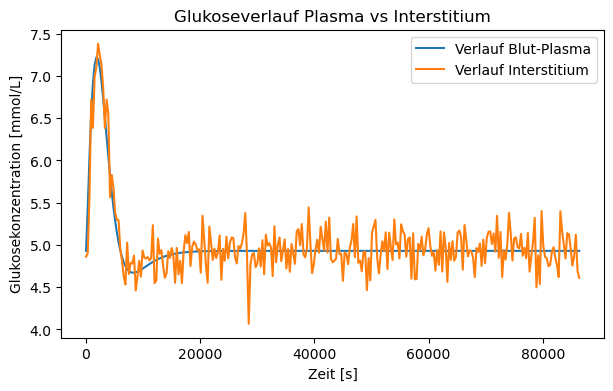

In [11]:
fig, ax = plt.subplots(1,1, figsize=(7,4))
ax.plot(t_eval, sim[:,1], label="Verlauf Blut-Plasma")
ax.plot(t_eval, sim[:,3], label="Verlauf Interstitium")
ax.set_title('Glukoseverlauf Plasma vs Interstitium')


ax.set_xlabel("Zeit [s]")
ax.set_ylabel("Glukosekonzentration [mmol/L]")

plt.legend()

In [12]:
from Test_UKF_ode_2 import f_odes_2

In [13]:
k1 = param.k1*0.8
k5 = param.k5*0.8
tau_g = param.tau_g*1.5

In [14]:
y_start = np.array([0, #M_gut_start
                    G_start, #G_pl_start
                    I_start, #I_pl_start
                    G_start, #G_i_start
                    k1, 
                    k5, 
                    tau_g]) 

In [15]:
sim_2 = f_solve(f_odes_2, y_start, t_eval, D)

In [16]:
len(sim_2[:,1])

289

In [17]:
sim_2[:,3]+=noise

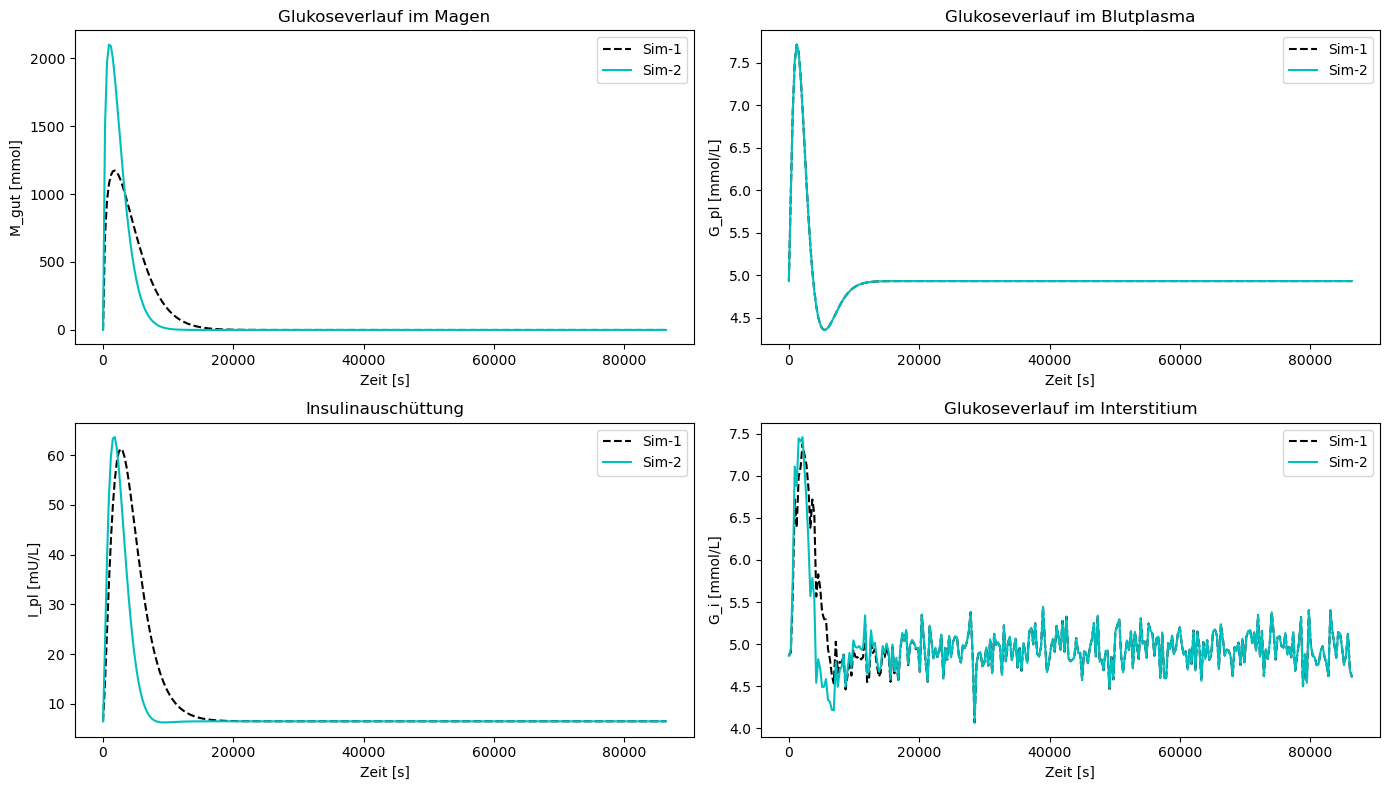

In [18]:
fig, ax = plt.subplots(2,2, figsize=(14,8))
ax[0,0].plot(t_eval, sim[:,0], "k--", label = "Sim-1")
ax[0,0].plot(t_eval, sim_2[:,0], color = "c", label = "Sim-2")
ax[0,0].legend()
ax[0,0].set_title('Glukoseverlauf im Magen')

ax[0,1].plot(t_eval, sim_2[:,1], "k--", label = "Sim-1")
ax[0,1].plot(t_eval, sim_2[:,1], color = "c", label = "Sim-2")
ax[0,1].legend()
ax[0,1].set_title('Glukoseverlauf im Blutplasma')

ax[1,0].plot(t_eval, sim[:,2], "k--", label = "Sim-1")
ax[1,0].plot(t_eval, sim_2[:,2], color = "c", label = "Sim-2")
ax[1,0].legend()
ax[1,0].set_title('Insulinauschüttung')

ax[1,1].plot(t_eval, sim[:,3], "k--", label = "Sim-1")
ax[1,1].plot(t_eval, sim_2[:,3], color = "c", label = "Sim-2")
ax[1,1].legend()
ax[1,1].set_title('Glukoseverlauf im Interstitium')

ax[0,0].set_xlabel("Zeit [s]")
ax[0,0].set_ylabel("M_gut [mmol]")

ax[0,1].set_xlabel("Zeit [s]")
ax[0,1].set_ylabel("G_pl [mmol/L]")

ax[1,0].set_xlabel("Zeit [s]")
ax[1,0].set_ylabel("I_pl [mU/L]")

ax[1,1].set_xlabel("Zeit [s]")
ax[1,1].set_ylabel("G_i [mmol/L]")

plt.tight_layout()

In [19]:
from Test_UKF_pyUKF import UKFException, UKF

In [20]:
#Prozessrauschen
#Werte von ChatGPT
Q = np.diag([
    1e-4,   # M_gut
    5e-4,   # G_pl
    5e-5,   # I_pl
    5e-4,   # G_i
    1e-9,   # k1
    1e-9,   # k5
    1e-10   # tau_g
])

In [21]:
delta_k1 = 0.0
delta_k5 = 0.0
delta_tau_g = 0.0

In [22]:
y_i = np.array([0, G_start,I_start,G_start, delta_k1, delta_k5, delta_tau_g])

In [23]:
#Messrauschen
# Schätzung von Varianzen mithilfe von Erlandsen-Paper (CV - Werte von Parametern mit ähnlicher Funktionalität) & ChatGPT
# CV = σ / μ
# var = σ^2

var_M_gut = 4 # Empfehlung ChatGPT
var_G_pl = ((0.027+0.077+0.027)/3*param.G_pl_b)**2 # CV-Werte für basale Glukose
var_I_pl = ((0.35+0.72)/2*param.I_pl_b)**2 # CV-Werte für Basales Insulin
var_G_i = var_G_pl*1.2 # Meine Annahme: Etwas grössere Unsicherheit als Basal-Glukose
var_k1 = 0.5*param.k1**2 # Empfehlung ChatGPT
var_k5 = 0.5*param.k5**2 # Empfehlung ChatGPT
var_tau_g = (0.2*param.tau_g)**2 # Empfehlung ChatGPT

In [24]:
covar = np.diag([
    var_M_gut, #M_gut
    var_G_pl, #G_pl
    var_I_pl, #I_pl
    var_G_i, #G_i
    var_k1, #k1
    var_k5, #k5
    var_tau_g #tau_g
])

In [25]:
def iterate_euler(y_in: np.ndarray, delta_t: float, inputs: tuple):
    '''Euler-Approximation der Integrationsfunktionen für EDES-Gleichungen'''
    D_meal, t_current = inputs
    y_next = np.zeros(len(y_in))
    dydt = f_odes_2(y_in, t_current, D_meal)
    y_next = y_in + dydt*delta_t
    return y_next

In [26]:
#num_states, process_noise, initial_state, initial_covar, alpha, k, beta, iterate_function
params = {
    "num_states" : 7,
    "process_noise" : Q,
    "initial_state" : y_i,
    "initial_covar" : covar,
    "alpha" : 1e-3, #Standardwert
    "k": 0, #Standardwert
    "beta" : 2.0, # Standardwert
    "iterate_function" : iterate_euler
}

In [27]:
# Erzeugen eines Datensets mit 3-Spalten für die simulierten Daten
# sim_data_set[0]: Zeit in s, sim_data_set[1]: simulierte CGM-Daten, sim_data_set[2]: Mahlzeiteninputs

t_eval # Zeit in s
cgm_data = sim_2[:,3] #simulierte CGM-Daten
D_inputs = np.zeros(shape=(len(t_eval))) #Mahlzeiteninputs
D_inputs[0] = 75000
sim_data_set = np.column_stack((cgm_data, D_inputs, t_eval, )) #vollständiges Datenset mit simulierten Daten
sim_data_set[0][1]

75000.0

In [28]:
estimator = UKF(**params)

In [29]:
step = 5
x_pred_hist = np.zeros((len(t_eval), 7))
x_upd_hist = np.zeros((len(t_eval), 7))

In [30]:
covar[3,3]

0.05561285185333332

In [31]:
for i, row in enumerate(sim_data_set):
    inputs = (row[1], row[2])
    cgm_data = row[0]
    estimator.predict(step, inputs)
    x_pred_hist[i] = estimator.get_state()
    estimator.update([3], cgm_data, covar[3,3])
    x_upd_hist[i] = estimator.get_state()

Sollte ich die Schätzung in einer Variable speichern?
Sollte ich die Berechnungszeit ausgeben?
Welche Rolle spielt update?

In [32]:
x_pred_hist[:5]

array([[ 6.73429108e+00,  4.93205303e+00,  6.52900937e+00,
         4.93000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 6.37905722e+00,  4.93105036e+00,  6.52884678e+00,
         4.89776291e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 6.04269485e+00,  4.93206695e+00,  6.52881484e+00,
         4.91033541e+00,  3.97649167e-09, -1.37836186e-18,
        -2.95214350e-03],
       [ 5.72961269e+00,  4.97034219e+00,  6.53134633e+00,
         5.13605259e+00,  1.83077060e-07, -3.52365337e-10,
        -1.08204053e-01],
       [ 5.44392392e+00,  5.08352848e+00,  6.53964269e+00,
         5.56349920e+00,  7.34904331e-07, -3.17331459e-09,
         6.62722557e-01]])

In [33]:
x_upd_hist[:5]

array([[ 6.73429108e+00,  4.93106026e+00,  6.52896243e+00,
         4.89656714e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 6.37919752e+00,  4.93207681e+00,  6.52888046e+00,
         4.90955574e+00,  3.97649165e-09,  0.00000000e+00,
        -2.95214350e-03],
       [ 6.04868059e+00,  4.97035548e+00,  6.52960462e+00,
         5.14200949e+00,  1.83077060e-07, -3.52365331e-10,
        -1.08204053e-01],
       [ 5.74708252e+00,  5.08355221e+00,  6.53256128e+00,
         5.58064515e+00,  7.34904331e-07, -3.17331459e-09,
         6.62722557e-01],
       [ 5.45747774e+00,  5.17624050e+00,  6.53992248e+00,
         5.83251136e+00,  1.18687623e-06, -7.51267348e-09,
         2.90769930e+00]])

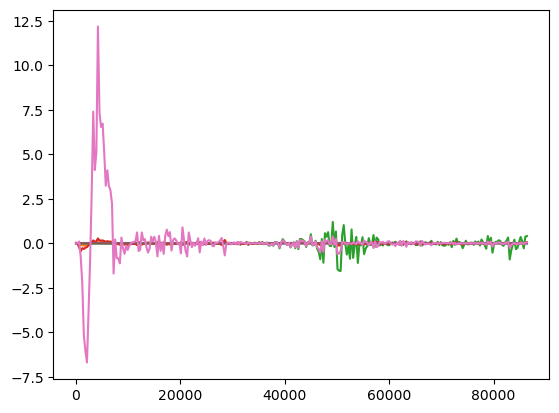

In [34]:
#Überprüfen, ob es Unterschiede gibt zwischen Prediction und Update --> arbeitet der Filter?
plt.plot(t_eval, x_pred_hist - x_upd_hist)

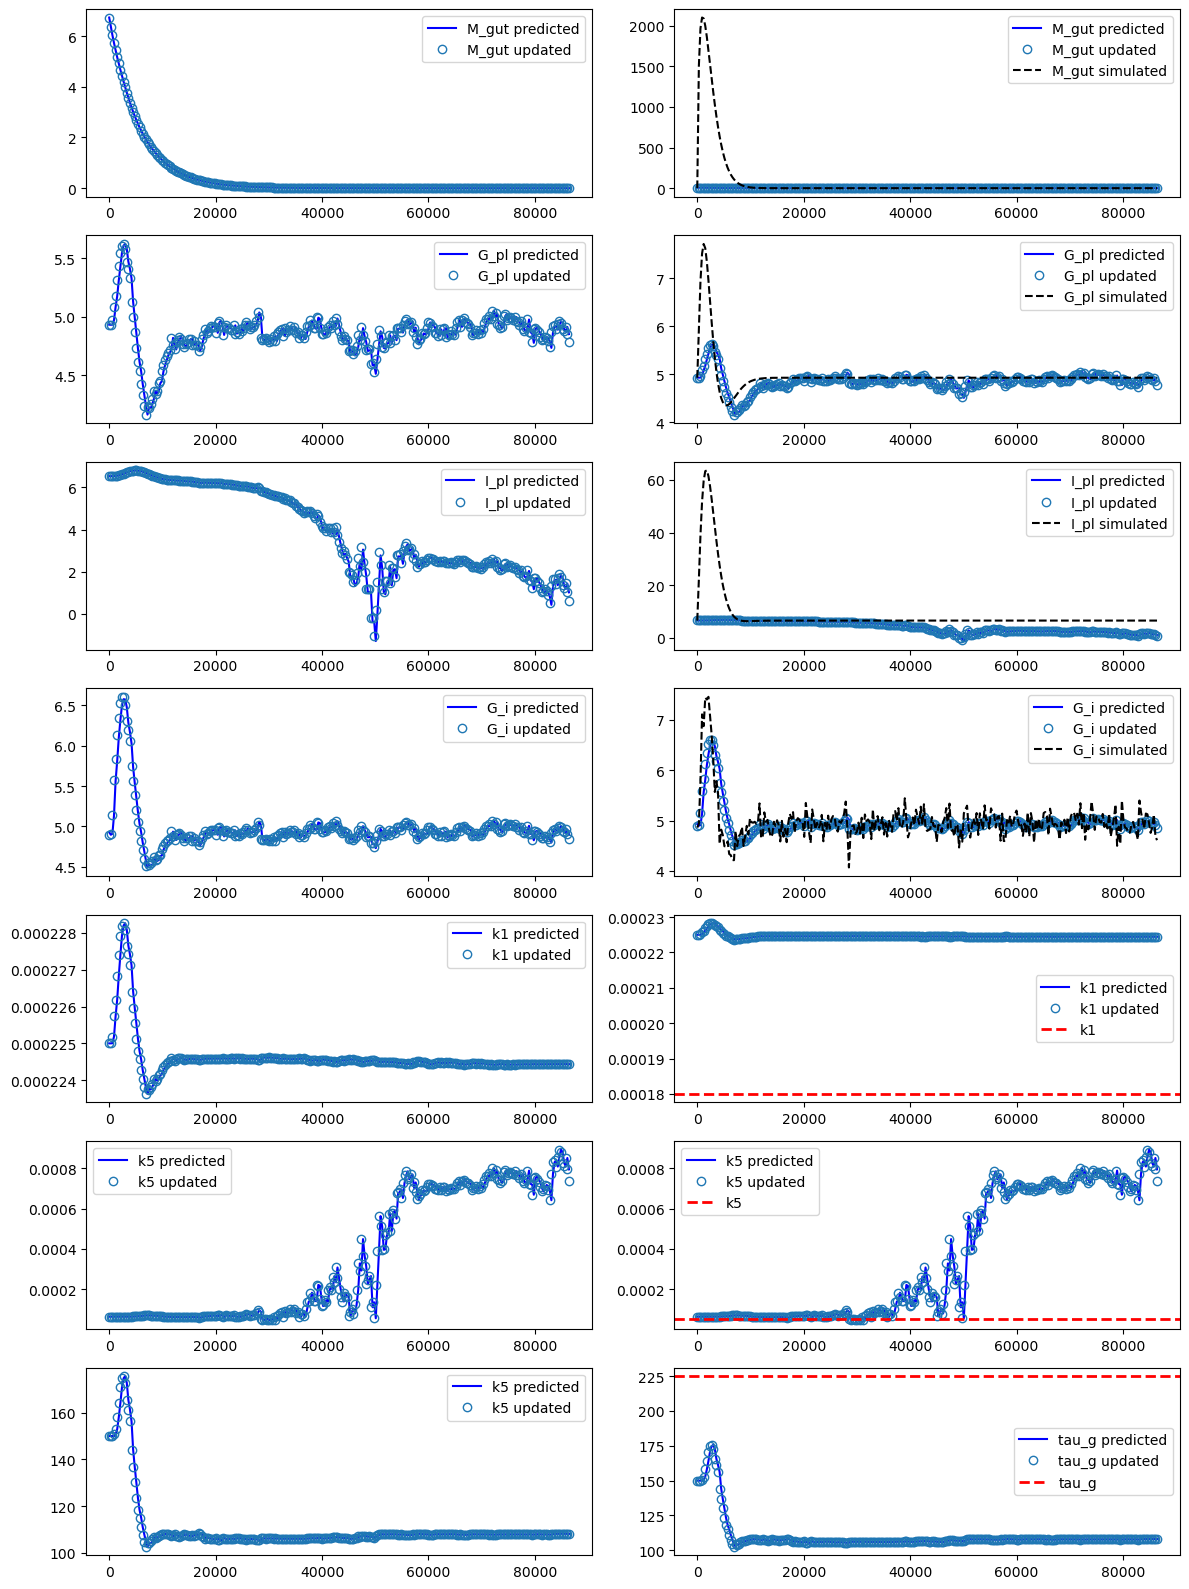

In [35]:
fig, ax = plt.subplots(7,2, figsize = (12, 16))

#UKF Magen/Darm
ax[0,0].plot(t_eval, x_pred_hist[:,0], "b", label = "M_gut predicted")
ax[0,0].plot(t_eval, x_upd_hist[:,0], "o", mfc='none', label = "M_gut updated")
ax[0,0].legend()

#Simulation vs UKF - Magen/Darm
ax[0,1].plot(t_eval, x_pred_hist[:,0], "b", label = "M_gut predicted")
ax[0,1].plot(t_eval, x_upd_hist[:,0], "o", mfc='none', label = "M_gut updated")
ax[0,1].plot(t_eval, sim_2[:,0], "k--", label = "M_gut simulated")
ax[0,1].legend()

#UKF Glukose Blut-Plasma
ax[1,0].plot(t_eval, x_pred_hist[:,1], "b", label = "G_pl predicted")
ax[1,0].plot(t_eval, x_upd_hist[:,1], "o", mfc='none', label = "G_pl updated")
ax[1,0].legend()

#Simulation vs UKF - Glukose im Blut-Plasma
ax[1,1].plot(t_eval, x_pred_hist[:,1], "b", label = "G_pl predicted")
ax[1,1].plot(t_eval, x_upd_hist[:,1], "o", mfc='none', label = "G_pl updated")
ax[1,1].plot(t_eval, sim_2[:,1], "k--", label = "G_pl simulated")
ax[1,1].legend()

#UKF Insulin Blut-Plasma
ax[2,0].plot(t_eval, x_pred_hist[:,2], "b", label = "I_pl predicted")
ax[2,0].plot(t_eval, x_upd_hist[:,2], "o", mfc='none', label = "I_pl updated")
ax[2,0].legend()

#Simulation vs UKF - Insulin im Blut-Plasma
ax[2,1].plot(t_eval, x_pred_hist[:,2], "b", label = "I_pl predicted")
ax[2,1].plot(t_eval, x_upd_hist[:,2], "o", mfc='none', label = "I_pl updated")
ax[2,1].plot(t_eval, sim_2[:,2], "k--", label = "I_pl simulated")
ax[2,1].legend()

#UKF Glukose Interstitium
ax[3,0].plot(t_eval, x_pred_hist[:,3], "b", label = "G_i predicted")
ax[3,0].plot(t_eval, x_upd_hist[:,3], "o", mfc='none', label = "G_i updated")
ax[3,0].legend()

#Simulation vs UKF - Insulin im Blut-Plasma
ax[3,1].plot(t_eval, x_pred_hist[:,3], "b", label = "G_i predicted")
ax[3,1].plot(t_eval, x_upd_hist[:,3], "o", mfc='none', label = "G_i updated")
ax[3,1].plot(t_eval, sim_2[:,3], "k--", label = "G_i simulated")
ax[3,1].legend()

#UKF k1
ax[4,0].plot(t_eval, x_pred_hist[:,4]+param.k1, "b", label = "k1 predicted")
ax[4,0].plot(t_eval, x_upd_hist[:,4]+param.k1, "o", mfc='none', label = "k1 updated")
ax[4,0].legend()

#UKF k1 vs realer k1
ax[4,1].plot(t_eval, x_pred_hist[:,4]+param.k1, "b", label = "k1 predicted")
ax[4,1].plot(t_eval, x_upd_hist[:,4]+param.k1, "o", mfc='none', label = "k1 updated")
ax[4,1].axhline(y=k1, color='r', linestyle='--', linewidth=2, label = "k1")
ax[4,1].legend()

#UKF k5
ax[5,0].plot(t_eval, x_pred_hist[:,5]+param.k5, "b", label = "k5 predicted")
ax[5,0].plot(t_eval, x_upd_hist[:,5]+param.k5, "o", mfc='none', label = "k5 updated")
ax[5,0].legend()

#UKF k5 vs realer k5
ax[5,1].plot(t_eval, x_pred_hist[:,5]+param.k5, "b", label = "k5 predicted")
ax[5,1].plot(t_eval, x_upd_hist[:,5]+param.k5, "o", mfc='none', label = "k5 updated")
ax[5,1].axhline(y=k5, color='r', linestyle='--', linewidth=2, label = "k5")
ax[5,1].legend()

#UKF tau_g
ax[6,0].plot(t_eval, x_pred_hist[:,6]+param.tau_g, "b", label = "k5 predicted")
ax[6,0].plot(t_eval, x_upd_hist[:,6]+param.tau_g, "o", mfc='none', label = "k5 updated")
ax[6,0].legend()

#UKF tau_g vs reales tau_g
ax[6,1].plot(t_eval, x_pred_hist[:,6]+param.tau_g, "b", label = "tau_g predicted")
ax[6,1].plot(t_eval, x_upd_hist[:,6]+param.tau_g, "o", mfc='none', label = "tau_g updated")
ax[6,1].axhline(y=tau_g, color='r', linestyle='--', linewidth=2, label = "tau_g")
ax[6,1].legend()

plt.tight_layout()

## Nur die Zustände des Modells schätzen ohne Parameter

#### A) Zustände, Simulationsdaten mit einem Mahlzeiteninput direkt nach Simulationsstart (sim_2)

In [36]:
#Prozessrauschen
#Werte von ChatGPT
Q_a = np.diag([
    1e-4,   # M_gut
    5e-4,   # G_pl
    5e-5,   # I_pl
    5e-4,   # G_i
])

In [37]:
#Startwerte
y_a = np.array([0, #M_gut
                G_start, #G_pl
                I_start, #I_pl
                G_start]) #G_i

In [38]:
#Messrauschen
covar_a = np.diag([
    var_M_gut, #M_gut
    var_G_pl, #G_pl
    var_I_pl, #I_pl
    var_G_i, #G_i
])

In [39]:
def iterate_euler_a(y_in: np.ndarray, delta_t: float, inputs: tuple):
    '''Euler-Approximation der Integrationsfunktionen für EDES-Gleichungen'''
    D_meal, t_current = inputs
    y_next = np.zeros(len(y_in))
    dydt = f_odes(y_in, t_current, D_meal)
    y_next = y_in + dydt*delta_t
    return y_next

In [40]:
#num_states, process_noise, initial_state, initial_covar, alpha, k, beta, iterate_function
params_a = {
    "num_states" : 4,
    "process_noise" : Q_a,
    "initial_state" : y_a,
    "initial_covar" : covar_a,
    "alpha" : 1e-3, #Standardwert
    "k": 0, #Standardwert
    "beta" : 2.0, # Standardwert
    "iterate_function" : iterate_euler_a
}

In [41]:
estimator_a = UKF(**params)

In [42]:
# Erzeugen eines Datensets mit 3-Spalten für die simulierten Daten
# sim_data_set[0]: Zeit in s, sim_data_set[1]: simulierte CGM-Daten, sim_data_set[2]: Mahlzeiteninputs

t_eval # Zeit in s
cgm_data = sim_2[:,3] #simulierte CGM-Daten
D_inputs = np.zeros(shape=(len(t_eval))) #Mahlzeiteninputs
D_inputs[0] = 75000
sim_data_4 = np.column_stack((cgm_data, D_inputs, t_eval, )) #vollständiges Datenset mit simulierten Daten
mask = sim_data_4[:,2] <= 20000
sim_data_a = sim_data_4[mask] #Kürzen des simulierten Datensatzes unter Zeitschritt 20000
sim_data_a[-1]

array([4.95441812e+00, 0.00000000e+00, 1.98010000e+04])

In [43]:
step_a = 1
x_pred_a = np.zeros((len(sim_data_a), 4))
x_upd_a = np.zeros((len(sim_data_a), 4))

In [48]:
estimator_a.n_dim

7

In [44]:
for i, row in enumerate(sim_data_a):
    inputs = (row[1], row[2])
    cgm = row[0]
    estimator_a.predict(step_a, inputs)
    x_pred_a[i] = estimator_a.get_state()
    estimator_a.update([3], cgm, covar_a[3,3])
    x_upd_a[i] = estimator_a.get_state()

ValueError: could not broadcast input array from shape (7,) into shape (4,)